# KNN Classification vs K-Means Clustering Comparison

This notebook compares:
- **KNN Classification**: Trained on 80 labeled points (20 per class: Vegetation, Forest, Urban, Agricultural)
- **K-Means Clustering**: Unsupervised clustering with K=4

Both methods are applied to ~12M points from the embeddings dataset.

## 1. Setup and Imports

We begin by importing necessary Python libraries for geospatial analysis (geopandas), machine learning (scikit-learn, PySpark ML), and visualization (matplotlib). We also configure the PySpark environment to ensure compatibility with local Python execution.

In [1]:
import os
import sys
import json
import time
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix

# Add current directory to path
if os.getcwd() not in sys.path:
    sys.path.append(os.getcwd())

# Import our custom K-means library
from kmeans_scalability.models import SparkMLKMeansModel

# Configure Python executable for Spark
os.environ['PYSPARK_PYTHON'] = sys.executable
os.environ['PYSPARK_DRIVER_PYTHON'] = sys.executable

print(f"Python: {sys.version}")
print("Libraries imported successfully")

Python: 3.11.14 (main, Dec  9 2025, 18:59:10) [MSC v.1944 64 bit (AMD64)]
Libraries imported successfully


## 2. Initialize Spark Session

We initialize a local SparkSession configured for memory-intensive operations. To handle the ~12 million data points efficiently, we allocate 16GB for both driver and executor memory and configure a dedicated temporary directory.

In [2]:
# Create Spark temporary directory
spark_temp_dir = os.path.join(os.getcwd(), "spark_temp")
os.makedirs(spark_temp_dir, exist_ok=True)

# Initialize Spark Session with sufficient memory for 12M points
spark = SparkSession.builder \
    .appName("KNN-vs-KMeans-Classification") \
    .master("local[*]") \
    .config("spark.driver.memory", "16g") \
    .config("spark.executor.memory", "16g") \
    .config("spark.driver.maxResultSize", "4g") \
    .config("spark.local.dir", spark_temp_dir) \
    .getOrCreate()

print(f"Spark Version: {spark.version}")
print(f"Master: {spark.sparkContext.master}")
print(f"Default Parallelism: {spark.sparkContext.defaultParallelism}")

Spark Version: 3.5.7
Master: local[*]
Default Parallelism: 24


## 3. Load Training Data (KNN Points)

The supervised learning component relies on `KNN_POINTS.geojson`, a manually labeled dataset containing 80 ground truth points distributed across 4 land cover classes: Vegetation, Forest, Urban, and Agricultural. We load this data and ensure its Coordinate Reference System (CRS) is transformed to EPSG:32630 (UTM Zone 30N) to match the satellite embeddings.

In [3]:
# Load the labeled KNN training points from GeoJSON
knn_points_path = "KNN_POINTS.geojson"

if not os.path.exists(knn_points_path):
    raise FileNotFoundError(f"Training data not found: {knn_points_path}")

# Load as GeoDataFrame
gdf_train = gpd.read_file(knn_points_path)

# Convert MultiPolygon to Point (centroid)
print(f"Original geometry type: {gdf_train.geometry.type.unique()}")
gdf_train['geometry'] = gdf_train.geometry.centroid
print(f"Converted to: {gdf_train.geometry.type.unique()}")

# Transform from EPSG:4326 to EPSG:32630 to match embeddings data
print(f"\nOriginal CRS: {gdf_train.crs}")
if gdf_train.crs.to_epsg() == 4326:
    gdf_train = gdf_train.to_crs(epsg=32630)
    print(f"Transformed to CRS: {gdf_train.crs}")
else:
    print(f"CRS is already: {gdf_train.crs}")

print(f"\nLoaded {len(gdf_train)} labeled points")
print(f"\nClass distribution:")
print(gdf_train['class'].value_counts())
print(f"\nColumns: {gdf_train.columns.tolist()}")

# Display first few rows
gdf_train.head()

Original geometry type: ['MultiPoint']
Converted to: ['Point']

Original CRS: EPSG:4326
Transformed to CRS: EPSG:32630

Loaded 80 labeled points

Class distribution:
class
Agricultural    20
Urban           20
Forest          20
Vegetation      20
Name: count, dtype: int64

Columns: ['id', 'class', 'geometry']


C:\Users\2012m\AppData\Local\Temp\ipykernel_3572\2443071215.py:12: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_train['geometry'] = gdf_train.geometry.centroid


,id,class,geometry
0,0,Agricultural,POINT (606445.232 4744118.375)
1,1,Agricultural,POINT (606871.11 4743668.837)
2,2,Agricultural,POINT (610853.858 4746019.052)
3,3,Agricultural,POINT (612951.701 4744772.965)
4,4,Agricultural,POINT (614844.492 4744063.168)


## 4. Load Full Dataset (Embeddings)

We load the GeoTessera dataset containing approximately 2 million Sentinel-2 satellite embeddings. The data is stored in Parquet format for efficiency. Each data point consists of a 128-dimensional feature vector representing a 10m x 10m pixel on the ground.

In [4]:
# Load the full embeddings dataset
parquet_path = "GeoTessera_Pamplona_embeddings.parquet"

if not os.path.exists(parquet_path):
    raise FileNotFoundError(f"Embeddings data not found: {parquet_path}")

print(f"Loading data from {parquet_path}...")
df_raw = spark.read.parquet(parquet_path)

# Identify feature columns (0 to 127)
skipcolumns = ['id', 'lon', 'lat']
feature_cols = [col for col in df_raw.columns if col not in skipcolumns]

print(f"Feature columns: {len(feature_cols)} dimensions")
print(f"First 10 features: {feature_cols[:10]}")

# Assemble features vector
assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")
df_full = assembler.transform(df_raw).select("id", "lon", "lat", "features")

# Cache for performance
df_full.cache()
total_points = df_full.count()
print(f"\nTotal points in dataset: {total_points:,}")
print("Data loaded and cached.")

Loading data from GeoTessera_Pamplona_embeddings.parquet...
Feature columns: 128 dimensions
First 10 features: ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']

Total points in dataset: 1,879,040
Data loaded and cached.


## 5. Extract Training Features from Full Dataset

Since the labeled points from the GeoJSON file might not perfectly align with the pixel centroids in the embeddings dataset, we use a KD-Tree spatial index to find the nearest neighbor embedding for each labeled coordinate. This allows us to extract the actual 128D feature vectors corresponding to our ground truth points.

In [5]:
# Extract coordinates from GeoJSON (assuming EPSG:32630 UTM coordinates)
# Get lon, lat from geometry
gdf_train['lon'] = gdf_train.geometry.x
gdf_train['lat'] = gdf_train.geometry.y

print(f"Training point coordinate range:")
print(f"  Lon: {gdf_train['lon'].min():.2f} to {gdf_train['lon'].max():.2f}")
print(f"  Lat: {gdf_train['lat'].min():.2f} to {gdf_train['lat'].max():.2f}")

# Convert to Pandas for easier joining
train_coords = gdf_train[['lon', 'lat', 'class']].copy()

# Since coordinates won't match exactly, use nearest neighbor matching
print("\nMatching training points to nearest embeddings...")
print("Collecting spatial index for nearest neighbor matching...")

# Collect full dataset coordinates for spatial matching
df_coords = df_raw.select("id", "lon", "lat").toPandas()

# Build KDTree for efficient nearest neighbor search
from scipy.spatial import KDTree

tree = KDTree(df_coords[['lon', 'lat']].values)
train_indices = []
distances = []

for idx, row in train_coords.iterrows():
    dist, ind = tree.query([row['lon'], row['lat']], k=1)
    train_indices.append(df_coords.iloc[ind]['id'])
    distances.append(dist)

train_coords['matched_id'] = train_indices
train_coords['distance'] = distances

print(f"Matched {len(train_coords)} training points")
print(f"Average distance to nearest point: {np.mean(distances):.2f} meters")
print(f"Max distance to nearest point: {np.max(distances):.2f} meters")

# Create Spark DataFrame and join with features
train_ids_spark = spark.createDataFrame(train_coords[['matched_id', 'class']].rename(columns={'matched_id': 'id'}))
df_train = df_full.join(train_ids_spark, on='id', how='inner')

train_count = df_train.count()
print(f"\nSuccessfully matched {train_count} training samples with embeddings")

Training point coordinate range:
  Lon: 606285.53 to 618951.45
  Lat: 4739735.38 to 4748110.98

Matching training points to nearest embeddings...
Matched 80 training points
Average distance to nearest point: 3.76 meters
Max distance to nearest point: 6.62 meters

Successfully matched 80 training samples with embeddings


## 6. Prepare Training Data for KNN

We prepare the matched training data for the Scikit-Learn classifier. This involves using Spark's `StringIndexer` to convert the categorical text labels (Vegetation, Forest, etc.) into numerical indices required by the algorithm.

In [6]:
# Convert class labels to numeric
from pyspark.ml.feature import StringIndexer

indexer = StringIndexer(inputCol="class", outputCol="label")
df_train = indexer.fit(df_train).transform(df_train)

# Show label mapping
label_mapping = df_train.select("class", "label").distinct().toPandas().sort_values("label")
print("\nClass to Label Mapping:")
print(label_mapping)

df_train.cache()
print(f"\nTraining data prepared: {df_train.count()} samples")


Class to Label Mapping:
          class  label
3  Agricultural    0.0
2        Forest    1.0
1         Urban    2.0
0    Vegetation    3.0

Training data prepared: 80 samples


## 7. Train KNN Classifier

We train a K-Nearest Neighbors (KNN) classifier with $k=5$ using Scikit-Learn. The model is trained on the small subset of 80 labeled points, learning the relationship between the 128-dimensional embeddings and the land cover classes.

In [7]:
# Collect training data for sklearn KNN (more reliable than Spark ML KNN)
print("Preparing KNN classifier...")
train_data = df_train.select("features", "label").collect()

# Convert to numpy arrays
X_train = np.array([row.features.toArray() for row in train_data])
y_train = np.array([row.label for row in train_data])

print(f"Training set shape: {X_train.shape}")
print(f"Label distribution: {np.bincount(y_train.astype(int))}")

# Train KNN classifier
print("\nTraining KNN classifier (k=5)...")
knn = KNeighborsClassifier(n_neighbors=5, n_jobs=-1)
knn.fit(X_train, y_train)
print("KNN classifier trained successfully!")

Preparing KNN classifier...
Training set shape: (80, 128)
Label distribution: [20 20 20 20]

Training KNN classifier (k=5)...
KNN classifier trained successfully!


## 8. Predict with KNN on Full Dataset

We scale the KNN model to the entire dataset of millions of points. To do this efficiently within the Spark ecosystem, we wrap the Scikit-Learn model's prediction function in a Spark User Defined Function (UDF) and apply it to the `features` column of the full DataFrame.

In [8]:
# For large datasets, we'll predict in batches using Spark
print("Predicting labels for all points using KNN...")
print("Note: This may take several minutes for 12M points\n")

from pyspark.sql.functions import udf
from pyspark.sql.types import DoubleType
from pyspark.ml.linalg import VectorUDT, Vectors
import pandas as pd

# Create a regular UDF for prediction (works better with ML Vectors)
@udf(returnType=DoubleType())
def predict_knn_udf(features):
    # Convert Spark ML vector to numpy array
    feature_array = features.toArray()
    # Predict using the trained KNN model
    prediction = knn.predict([feature_array])[0]
    return float(prediction)

# Apply prediction
start_time = time.time()
df_knn_predictions = df_full.withColumn("knn_prediction", predict_knn_udf("features"))
df_knn_predictions.cache()

# Force computation
knn_pred_count = df_knn_predictions.count()
knn_time = time.time() - start_time

print(f"KNN prediction completed: {knn_pred_count:,} points in {knn_time:.2f} seconds")
print(f"\nPrediction distribution:")
df_knn_predictions.groupBy("knn_prediction").count().orderBy("knn_prediction").show()

Predicting labels for all points using KNN...
Note: This may take several minutes for 12M points

KNN prediction completed: 1,879,040 points in 484.27 seconds

Prediction distribution:
+--------------+------+
|knn_prediction| count|
+--------------+------+
|           0.0|397079|
|           1.0|707213|
|           2.0|327784|
|           3.0|446964|
+--------------+------+



## 9. Run K-Means Clustering (K=4)

We perform unsupervised K-Means clustering using Spark MLlib with $K=4$ clusters. Unlike KNN, this method does not use any labels; instead, it attempts to find natural groupings in the high-dimensional data that ideally correspond to different land cover types.

In [9]:
# Train K-Means with K=4
print("Training K-Means clustering (K=4)...\n")

kmeans_model = SparkMLKMeansModel(k=4, max_iter=20, seed=42)
kmeans_model.fit(df_full.select("features"))

print(f"K-Means training completed in {kmeans_model.training_time:.2f} seconds")
print(f"WSSSE: {kmeans_model.training_cost:.2f}")

# Get cluster assignments
df_kmeans_predictions = kmeans_model.model.transform(df_full)
df_kmeans_predictions.cache()

print(f"\nCluster distribution:")
df_kmeans_predictions.groupBy("prediction").count().orderBy("prediction").show()

Training K-Means clustering (K=4)...

Training Spark ML K-means with k=4...
Training completed in 15.18 seconds
Within Set Sum of Squared Errors (WSSSE): 540932379.80
K-Means training completed in 15.18 seconds
WSSSE: 540932379.80

Cluster distribution:
+----------+------+
|prediction| count|
+----------+------+
|         0|365124|
|         1|584230|
|         2|628524|
|         3|301162|
+----------+------+



## 10. Combine Results for Comparison

We join the results from the supervised KNN classification and the unsupervised K-Means clustering into a single DataFrame. This side-by-side comparison allows us to evaluate how well the unsupervised clusters align with the interpretable land cover classes.

In [10]:
# Join KNN and K-Means predictions
df_comparison = df_knn_predictions.join(
    df_kmeans_predictions.select("id", df_kmeans_predictions.prediction.alias("kmeans_prediction")),
    on="id",
    how="inner"
)

df_comparison.cache()
print(f"Combined results: {df_comparison.count():,} points")
df_comparison.select("id", "lon", "lat", "knn_prediction", "kmeans_prediction").show(10)

Combined results: 1,879,040 points
+----+----------------+-----------------+--------------+-----------------+
|  id|             lon|              lat|knn_prediction|kmeans_prediction|
+----+----------------+-----------------+--------------+-----------------+
|  26|606393.215021294|4750660.725288692|           3.0|                2|
|  29|606423.215021294|4750660.725288692|           3.0|                2|
| 474|610873.215021294|4750660.725288692|           3.0|                2|
| 964|607423.215021294|4750650.725288692|           0.0|                0|
|1677|606203.215021294|4750640.725288692|           3.0|                2|
|1697|606403.215021294|4750640.725288692|           3.0|                2|
|1806|607493.215021294|4750640.725288692|           0.0|                2|
|1950|608933.215021294|4750640.725288692|           1.0|                1|
|2040|609833.215021294|4750640.725288692|           3.0|                2|
|2214|611573.215021294|4750640.725288692|           1.0|         

## 11. Visualize KNN and K-Means Mosaics

To verify the results visually, we reconstruct spatial images (mosaics) from the point data. We rasterize the predictions onto a grid with 10-meter resolution, generating side-by-side maps of the KNN classification and K-Means clustering results.

In [11]:
# Import visualization functions
from kmeans_scalability.visualization import create_mosaic, plot_mosaic, plot_comparison
import rasterio
from rasterio.transform import from_bounds

print("Visualization functions imported successfully")

Visualization functions imported successfully


In [14]:

print("Preparing data for spatial reconstruction...")

pdf_comparison = df_comparison.select("id", "lon", "lat", "knn_prediction", "kmeans_prediction").toPandas()

print(f"Total points: {len(pdf_comparison):,}")
print(f"\nCoordinate range:")
print(f"  Lon: {pdf_comparison['lon'].min():.2f} to {pdf_comparison['lon'].max():.2f}")
print(f"  Lat: {pdf_comparison['lat'].min():.2f} to {pdf_comparison['lat'].max():.2f}")

# To create a mosaic, we need to define the spatial resolution

# Define resolution (in meters, assuming UTM)
resolution = 10 # 30 meters per pixel (similar to Landsat)

# Calculate bounds
min_lon, max_lon = pdf_comparison['lon'].min(), pdf_comparison['lon'].max()
min_lat, max_lat = pdf_comparison['lat'].min(), pdf_comparison['lat'].max()

# Calculate grid dimensions
width = int(np.ceil((max_lon - min_lon) / resolution))
height = int(np.ceil((max_lat - min_lat) / resolution))

print(f"\nMosaic dimensions: {width} x {height} pixels")
print(f"Resolution: {resolution} meters/pixel")

Preparing data for spatial reconstruction...
Total points: 1,879,040

Coordinate range:
  Lon: 606133.22 to 622647.43
  Lat: 4739430.73 to 4750801.40

Mosaic dimensions: 1652 x 1138 pixels
Resolution: 10 meters/pixel


In [15]:
# Create rasterized grids for KNN and K-Means
print("Rasterizing KNN predictions...")

# Initialize mosaics with -1 (no data)
knn_mosaic = np.full((height, width), -1, dtype=np.int32)
kmeans_mosaic = np.full((height, width), -1, dtype=np.int32)

# Map each point to its corresponding pixel
for idx, row in pdf_comparison.iterrows():
    # Calculate pixel indices
    col = int((row['lon'] - min_lon) / resolution)
    row_idx = int((max_lat - row['lat']) / resolution)  # Invert Y axis
    
    # Ensure we're within bounds
    if 0 <= col < width and 0 <= row_idx < height:
        knn_mosaic[row_idx, col] = int(row['knn_prediction'])
        kmeans_mosaic[row_idx, col] = int(row['kmeans_prediction'])
    
    # Show progress every 1M points
    if (idx + 1) % 1000000 == 0:
        print(f"  Processed {idx + 1:,} points...")

print(f"\n✓ Rasterization completed")
print(f"  KNN pixels assigned: {np.sum(knn_mosaic >= 0):,}")
print(f"  K-Means pixels assigned: {np.sum(kmeans_mosaic >= 0):,}")

# Calculate extent for visualization
extent = [min_lon, max_lon, min_lat, max_lat]
print(f"\nExtent: {extent}")

Rasterizing KNN predictions...
  Processed 1,000,000 points...

✓ Rasterization completed
  KNN pixels assigned: 1,857,931
  K-Means pixels assigned: 1,857,931

Extent: [np.float64(606133.215021294), np.float64(622647.4260221977), np.float64(4739430.725288692), np.float64(4750801.402396928)]


Generating K-Means visualization...


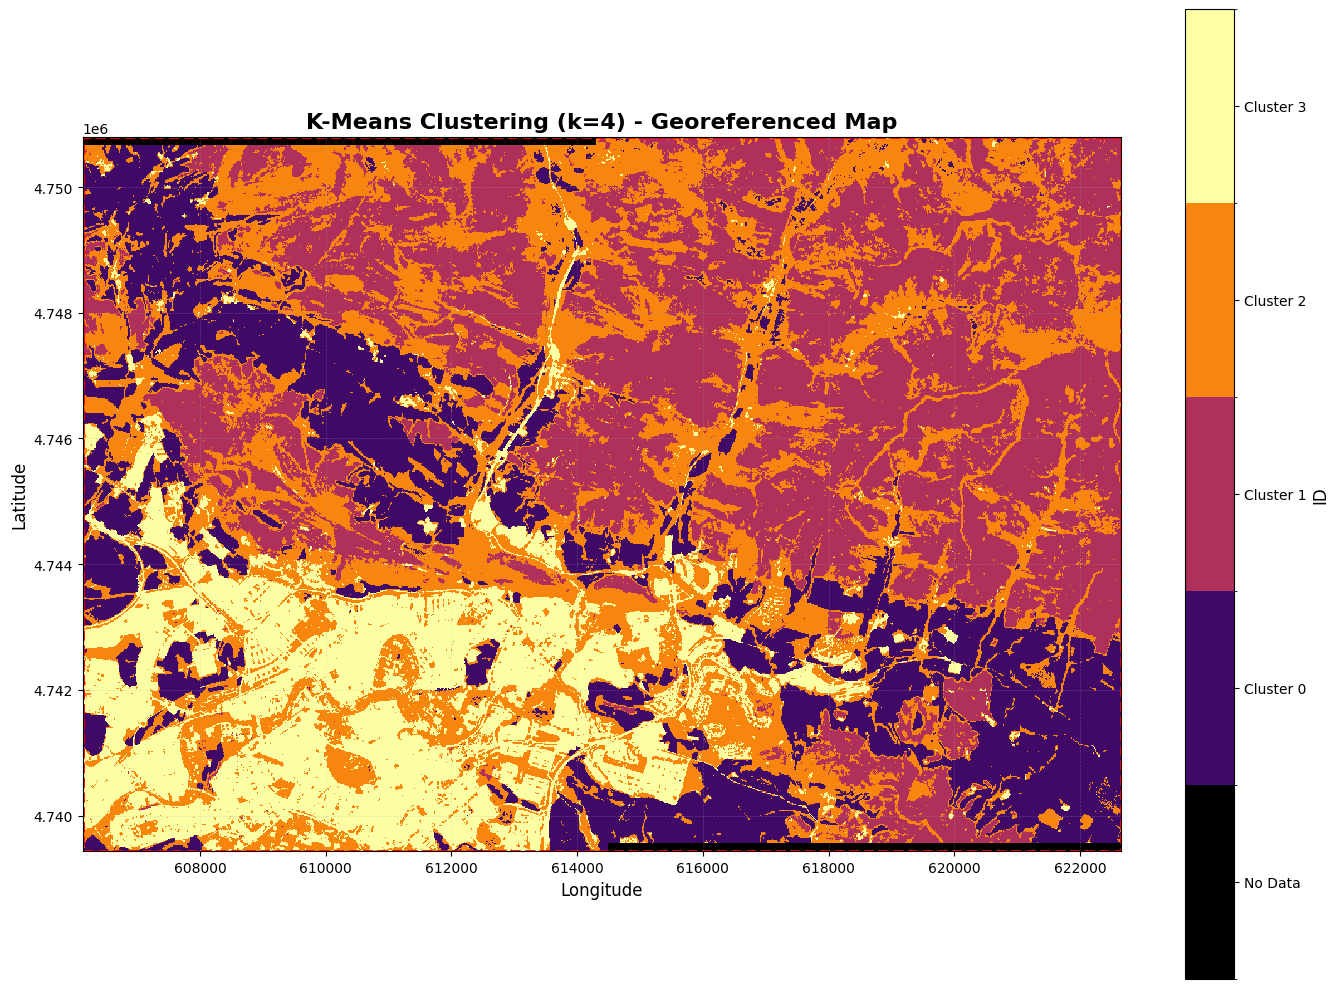

In [19]:

print("Generating K-Means visualization...")

k = 4
plot_mosaic(
    mosaic=kmeans_mosaic, 
    extent=extent, 
    k=k, 
    title='K-Means Clustering (k=4) - Georeferenced Map',
    label_prefix='Cluster'
)

Generating KNN visualization...


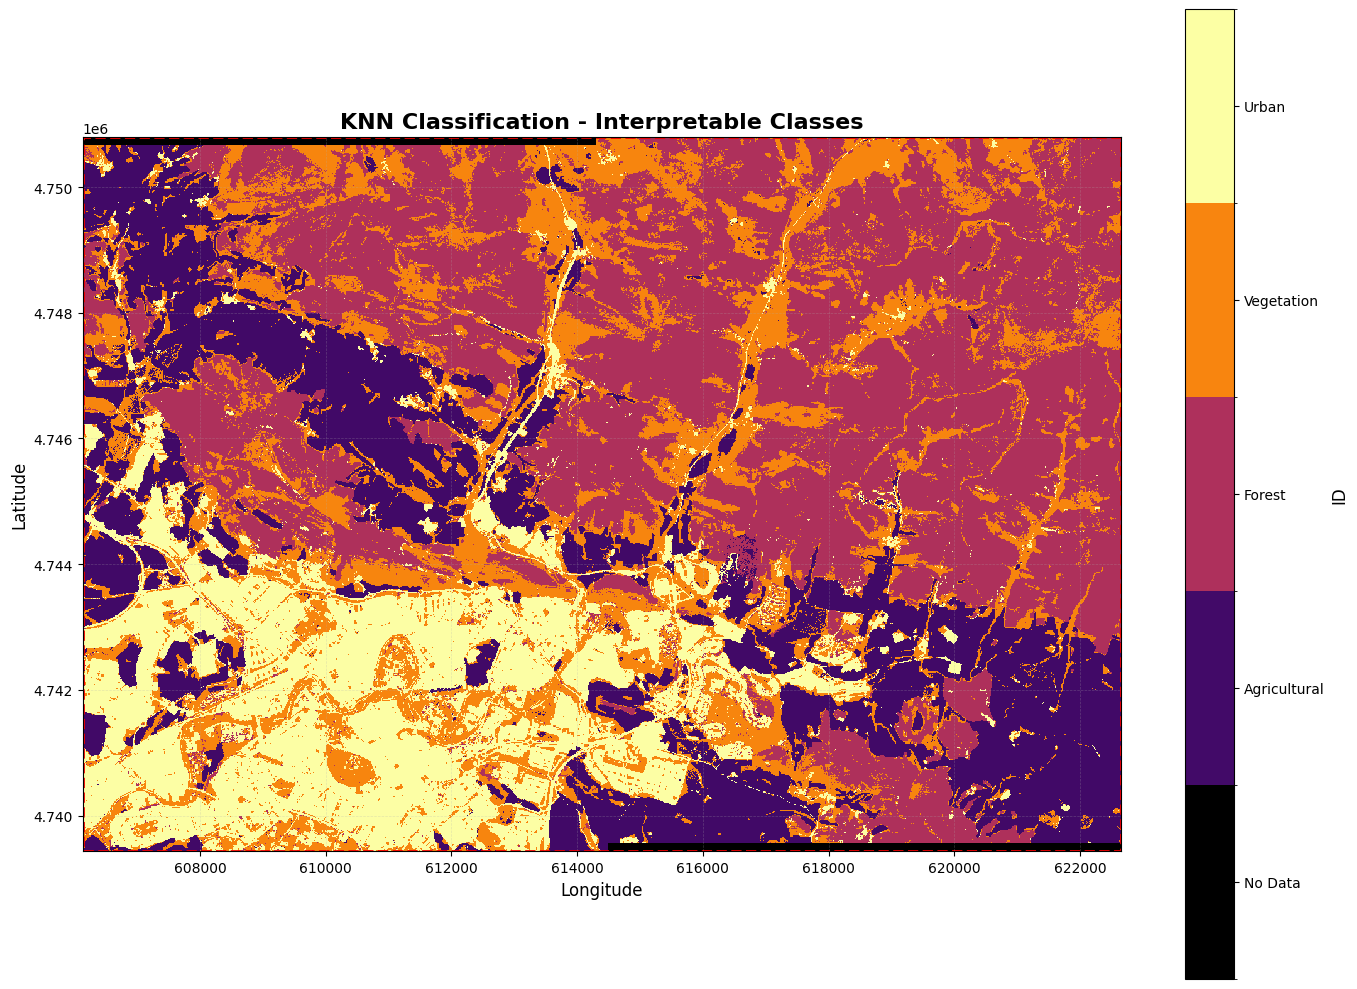

In [18]:
# Swap labels 2 and 3 in knn_mosaic
knn_mosaic_swapped = knn_mosaic.copy()
knn_mosaic_swapped[knn_mosaic == 2] = -99 
knn_mosaic_swapped[knn_mosaic == 3] = 2
knn_mosaic_swapped[knn_mosaic_swapped == -99] = 3



print("Generating KNN visualization...")

class_names = {
    2: 'Vegetation',
    1: 'Forest', 
    3: 'Urban',
    0: 'Agricultural'
}

plot_mosaic(
    mosaic=knn_mosaic_swapped, 
    extent=extent, 
    k=4, 
    title='KNN Classification - Interpretable Classes',
    label_prefix='Class',
    class_names=class_names
)

Generating side-by-side comparison...


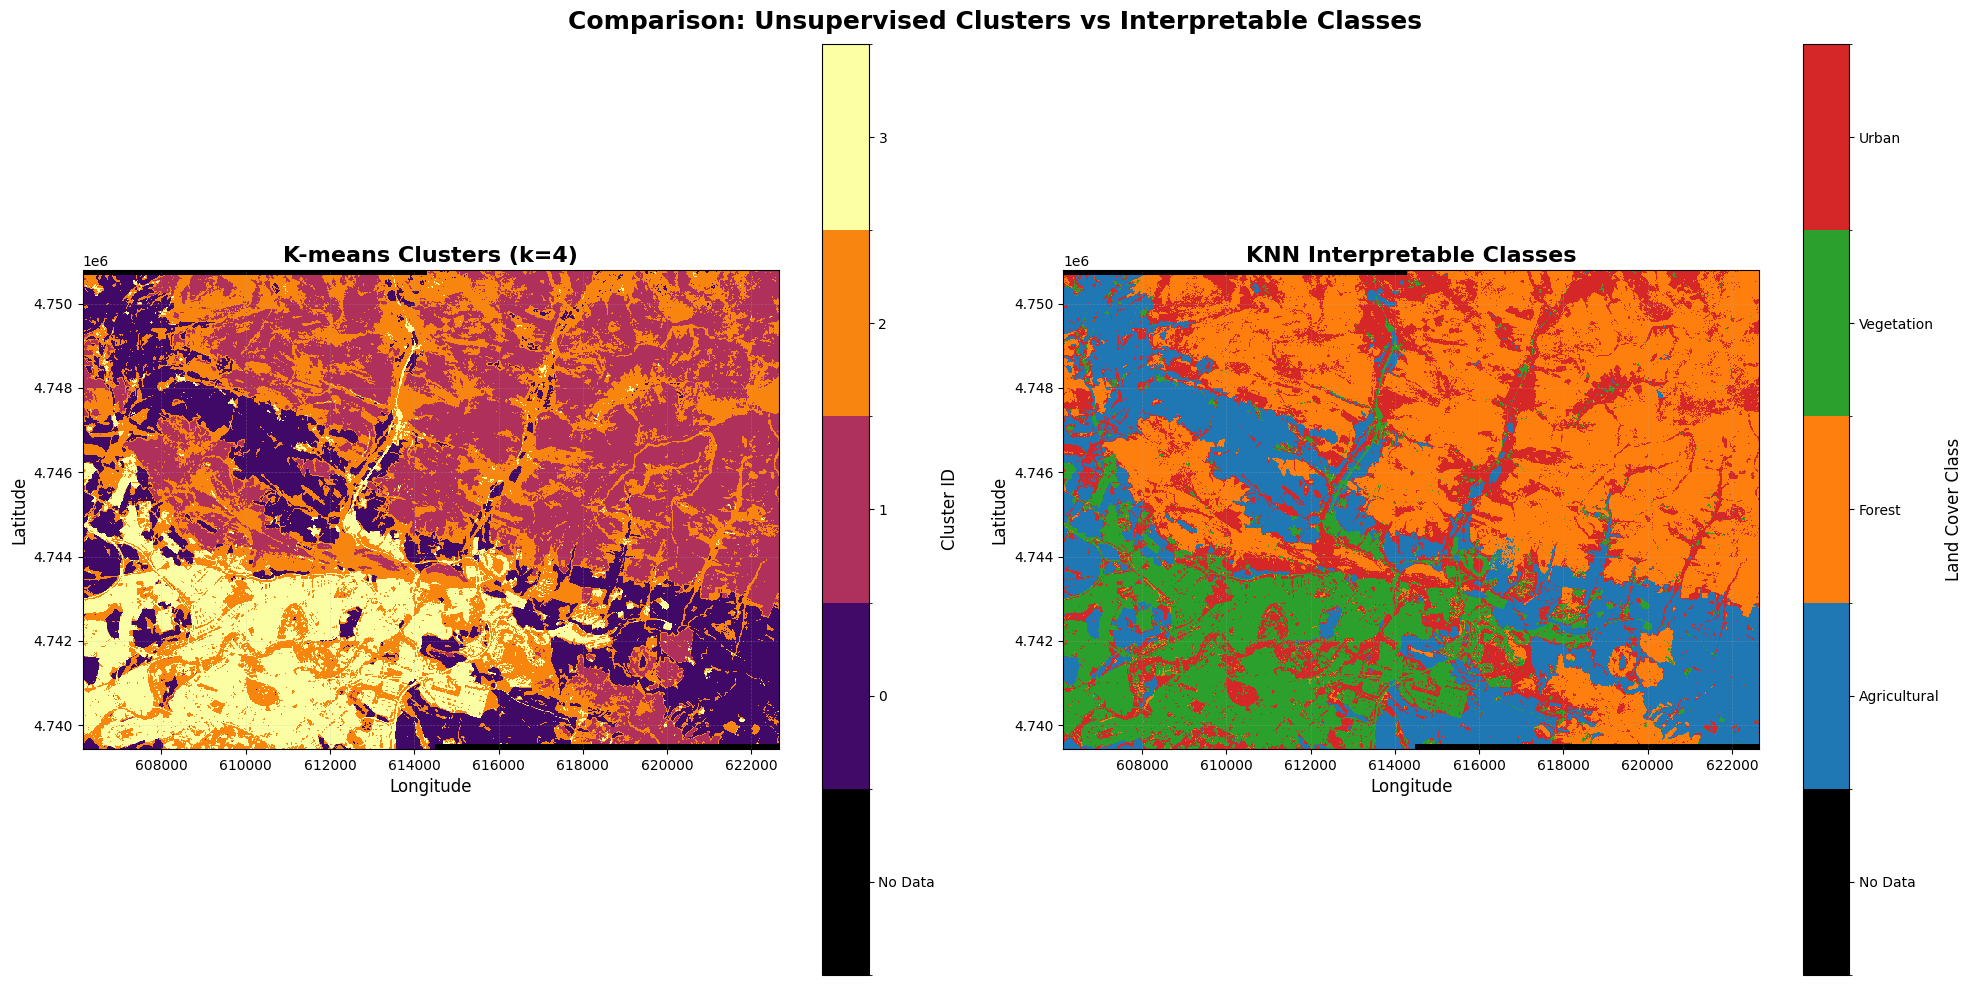

In [20]:
print("Generating side-by-side comparison...")

plot_comparison(
    cluster_mosaic=kmeans_mosaic,
    knn_mosaic=knn_mosaic,
    extent=extent,
    k=4,
    class_names=class_names
)

## 12. PCA 2D: K-Means and KNN Centroids

We use Principal Component Analysis (PCA) to project the 128-dimensional embeddings down to 2 dimensions. This visualization helps us understand the separation between classes and shows where the K-Means centroids and KNN centroids are located within the feature space.

Preparing PCA 2D visualization with centroids and training points...
Samples for PCA: 10,052
Feature dimension: 128

Applying PCA...
Explained variance: 41.48%
  PC1: 27.39%
  PC2: 14.09%

K-Means centroids: 4

Computing KNN centroids from predictions...
KNN centroids: 4

Transforming training points to PCA space...
Training points: 80


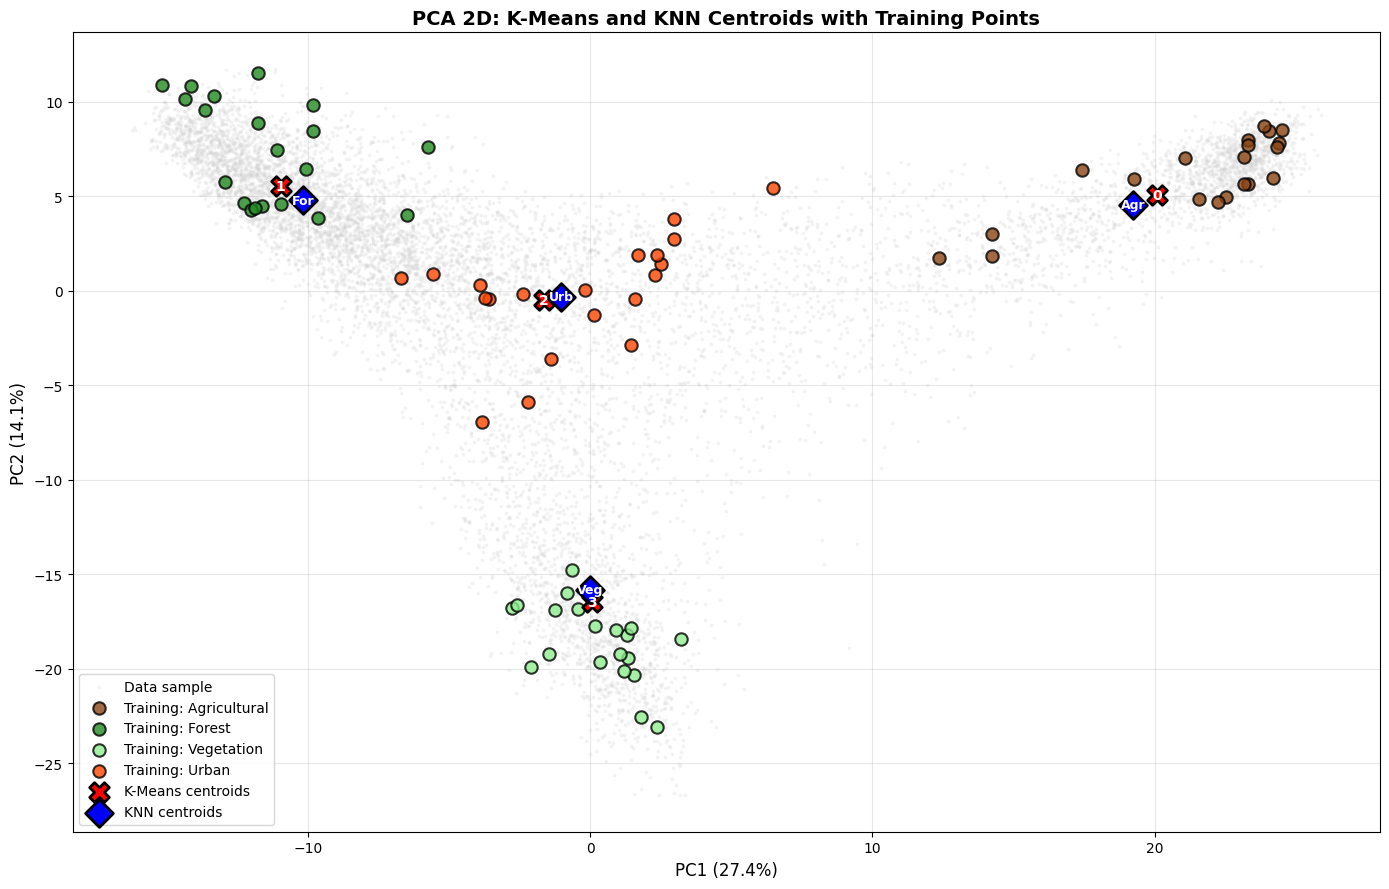


✓ Visualization completed


In [21]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np

print("Preparing PCA 2D visualization with centroids and training points...")

# Sample data for PCA (using all data would be too heavy)
sample_size = 10000
df_sample = df_full.sample(fraction=sample_size/df_full.count(), seed=42)
pdf_sample = df_sample.select("features").toPandas()

# Convert features from Spark ML Vector to numpy array
X_sample = np.array([row.toArray() for row in pdf_sample['features']])

print(f"Samples for PCA: {X_sample.shape[0]:,}")
print(f"Feature dimension: {X_sample.shape[1]}")

# Apply PCA to 2 dimensions
print("\nApplying PCA...")
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_sample)

print(f"Explained variance: {pca.explained_variance_ratio_.sum():.2%}")
print(f"  PC1: {pca.explained_variance_ratio_[0]:.2%}")
print(f"  PC2: {pca.explained_variance_ratio_[1]:.2%}")

# Get K-Means centroids
kmeans_centers = kmeans_model.model.clusterCenters()
kmeans_centers_array = np.array(kmeans_centers)

# Transform K-Means centroids to PCA space
kmeans_centers_pca = pca.transform(kmeans_centers_array)

print(f"\nK-Means centroids: {len(kmeans_centers_pca)}")

# For KNN, compute centroids based on predictions
print("\nComputing KNN centroids from predictions...")

# Sample KNN predictions to compute centroids
df_knn_sample = df_knn_predictions.sample(fraction=sample_size/df_knn_predictions.count(), seed=42)
pdf_knn_sample = df_knn_sample.select("features", "knn_prediction").toPandas()

# Compute centroids per predicted class
knn_centers = []
knn_labels = sorted(pdf_knn_sample['knn_prediction'].unique())

for label in knn_labels:
    mask = pdf_knn_sample['knn_prediction'] == label
    if mask.sum() > 0:
        features_in_class = np.array([row.toArray() 
                                      for row in pdf_knn_sample[mask]['features']])
        centroid = features_in_class.mean(axis=0)
        knn_centers.append(centroid)

knn_centers_array = np.array(knn_centers)
knn_centers_pca = pca.transform(knn_centers_array)

print(f"KNN centroids: {len(knn_centers_pca)}")

# Get training points and transform to PCA space
print("\nTransforming training points to PCA space...")
X_train_pca = pca.transform(X_train)
print(f"Training points: {len(X_train_pca)}")

# Create visualization
plt.figure(figsize=(14, 9))

# Plot sample points (semi-transparent)
plt.scatter(X_pca[:, 0], X_pca[:, 1], 
           c='lightgray', alpha=0.2, s=3, label='Data sample')

# Define colors for each class
class_colors = {
    0: '#8B4513',  # Agricultural - brown
    1: '#228B22',  # Forest - forest green
    2: '#90EE90',  # Vegetation - light green
    3: '#FF4500'   # Urban - orange-red
}

# Plot training points by class
for label_idx in sorted(np.unique(y_train)):
    mask = y_train == label_idx
    label_name = class_names.get(int(label_idx), f'Class {int(label_idx)}')
    plt.scatter(X_train_pca[mask, 0], X_train_pca[mask, 1],
               c=class_colors[int(label_idx)], s=80, marker='o', 
               edgecolors='black', linewidths=1.5,
               label=f'Training: {label_name}', zorder=4, alpha=0.8)

# Plot K-Means centroids
plt.scatter(kmeans_centers_pca[:, 0], kmeans_centers_pca[:, 1],
           c='red', s=200, marker='X', edgecolors='black', linewidths=2,
           label='K-Means centroids', zorder=5)

# Add labels to K-Means centroids
for i, (x, y) in enumerate(kmeans_centers_pca):
    plt.annotate(f'{i}', (x, y), fontsize=10, fontweight='bold',
                ha='center', va='center', color='white', zorder=6)

# Plot KNN centroids
plt.scatter(knn_centers_pca[:, 0], knn_centers_pca[:, 1],
           c='blue', s=200, marker='D', edgecolors='black', linewidths=2,
           label='KNN centroids', zorder=5)

# Add labels to KNN centroids
for i, (x, y) in enumerate(knn_centers_pca):
    label_name = class_names.get(int(knn_labels[i]), f'Class {int(knn_labels[i])}')
    plt.annotate(label_name[:3], (x, y), fontsize=9, fontweight='bold',
                ha='center', va='center', color='white', zorder=6)

plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%})', fontsize=12)
plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%})', fontsize=12)
plt.title('PCA 2D: K-Means and KNN Centroids with Training Points', fontsize=14, fontweight='bold')
plt.legend(loc='best', fontsize=10, ncol=1)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("\n✓ Visualization completed")

## 13. Save Mosaics as GeoTIFF

Finally, we export the reconstructed mosaics as GeoTIFF files. These georeferenced images retain spatial metadata (EPSG:32630), making them suitable for further analysis or overlay in GIS software like QGIS.

In [25]:
import rasterio
from rasterio.transform import from_bounds

print("Saving mosaics as GeoTIFF files...")

# Create output directory if it doesn't exist
output_dir = "output_mosaics"
os.makedirs(output_dir, exist_ok=True)

# Define output paths
kmeans_output_path = os.path.join(output_dir, "kmeans_mosaic.tiff")
knn_output_path = os.path.join(output_dir, "knn_mosaic.tiff")

# Calculate transform from bounds
# extent = [min_lon, max_lon, min_lat, max_lat]
transform = from_bounds(
    west=extent[0],
    south=extent[2],
    east=extent[1],
    north=extent[3],
    width=width,
    height=height
)

# Metadata for GeoTIFF
metadata = {
    'driver': 'GTiff',
    'dtype': 'int16',
    'nodata': -1,
    'width': width,
    'height': height,
    'count': 1,
    'crs': 'EPSG:32630',  # UTM Zone 30N
    'transform': transform,
    'compress': 'lzw'
}

# Save K-Means mosaic
print(f"\nSaving K-Means mosaic to {kmeans_output_path}...")
with rasterio.open(kmeans_output_path, 'w', **metadata) as dst:
    dst.write(kmeans_mosaic.astype('int16'), 1)
    dst.set_band_description(1, 'K-Means Cluster')

print(f"✓ K-Means mosaic saved")
print(f"  Size: {width} x {height} pixels")
print(f"  Resolution: {resolution} meters/pixel")
print(f"  CRS: EPSG:32630")

# Save KNN mosaic
print(f"\nSaving KNN mosaic to {knn_output_path}...")
with rasterio.open(knn_output_path, 'w', **metadata) as dst:
    dst.write(knn_mosaic_swapped.astype('int16'), 1)
    dst.set_band_description(1, 'KNN Classification')

print(f"✓ KNN mosaic saved")


Saving mosaics as GeoTIFF files...

Saving K-Means mosaic to output_mosaics\kmeans_mosaic.tiff...
✓ K-Means mosaic saved
  Size: 1652 x 1138 pixels
  Resolution: 10 meters/pixel
  CRS: EPSG:32630

Saving KNN mosaic to output_mosaics\knn_mosaic.tiff...
✓ KNN mosaic saved


In [26]:
# Stop Spark session when done
# spark.stop()
# print("Spark session stopped.")